In [303]:
import pandas as pd
df = pd.read_csv('/Users/phuong/Documents/AAAI_Project/All_Articles.csv',encoding ='latin1')
df.head()

,PMID,Article Title,Abstract,Publication Type,Methods Section,First Label,Second Label,Third Label,hydroxymethylglutaryl,acetaminophen,...,tramadol,trazodone,triazolam,valproate,venlafaxine,verapamil,voriconazole,warfarin,ziprasidone,zolpidem
0,8646822,A kinetic and dynamic study of oral alprazolam...,To assess the possible involvement of CYP3A4 i...,Clinical Trial ;Journal Article ;Randomized Co...,methods subjects twelve unrelated healthy male...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8453848,A potentially hazardous interaction between er...,Interaction between erythromycin and midazolam...,Clinical Trial ;Journal Article ;Randomized Co...,material and methods study design orally admin...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial,0,0,...,0,0,0,0,0,0,0,0,0,0
2,23210726,A semi-mechanistic absorption model to evaluat...,The aim of this study was to develop a PK/PD m...,Journal Article ;Randomized Controlled Trial ;...,methods ten healthy male volunteers randomized...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11936570,A study of the interaction potential of azithr...,Atorvastatin is a common option among the HMG-...,"Clinical Trial ;Clinical Trial, Phase I ;Compa...",materials and methods this randomized open lab...,DDI Clinical Trial,RCT DDI Clinical Trial,RCT DDI Clinical Trial,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1387301,Absolute bioavailability of clarithromycin aft...,The absolute bioavailability of clarithromycin...,Clinical Trial ;Comparative Study ;Journal Art...,clarithromycin new 14 membered macrolide antim...,PK Trial,PK Trial,PK Trial,0,0,...,0,0,0,0,0,0,0,0,0,0


In [304]:
from io import StringIO

col = ['Article Title','Abstract','Methods Section','First Label','Second Label',"Third Label"]
df = df[col]
df = df[pd.notnull(df['Abstract'])]

#generate categorize_id level 1 based on First Label
df.columns = ['Article Title','Abstract','Methods Section','First Label','Second Label',"Third Label"]
df['category_id_1'] = df['First Label'].factorize()[0]
category_id_df = df[['First Label', 'category_id_1']].drop_duplicates().sort_values('category_id_1')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id_1', 'First Label']].values)

#generate categorize_id level 2 based on Second Label
df['category_id_2'] = df['Second Label'].factorize()[0]
category_id_df_2 = df[['Second Label', 'category_id_2']].drop_duplicates().sort_values('category_id_2')
category_to_id_2 = dict(category_id_df_2.values)
id_to_category_2 = dict(category_id_df_2[['category_id_2', 'Second Label']].values)

#generate categorize_id level 3 based on Second Label
df['category_id_3'] = df['Third Label'].factorize()[0]
category_id_df_3 = df[['Third Label', 'category_id_3']].drop_duplicates().sort_values('category_id_3')
category_to_id_3 = dict(category_id_df_3.values)
id_to_category_3 = dict(category_id_df_3[['category_id_3', 'Third Label']].values)

df.head(100)

df.to_excel('/Users/phuong/Documents/AAAI_Project/All_Articles_Processed.xls', encoding='utf-8')

In [305]:
#Read the drug entities features
import pandas as pd
df1 = pd.read_csv('/Users/phuong/Documents/AAAI_Project/All_Drug_Entities_Features.csv',encoding ='latin1')

Accuracy: 0.7567567567567568
Precision: 0.661122661122661
Recall: 0.7567567567567568
F1 score: 0.6863226863226863
              precision    recall  f1-score   support

           0       0.69      1.00      0.82        18
           1       1.00      0.50      0.67         4
           2       0.89      0.89      0.89         9
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3

   micro avg       0.76      0.76      0.76        37
   macro avg       0.43      0.40      0.40        37
weighted avg       0.66      0.76      0.69        37



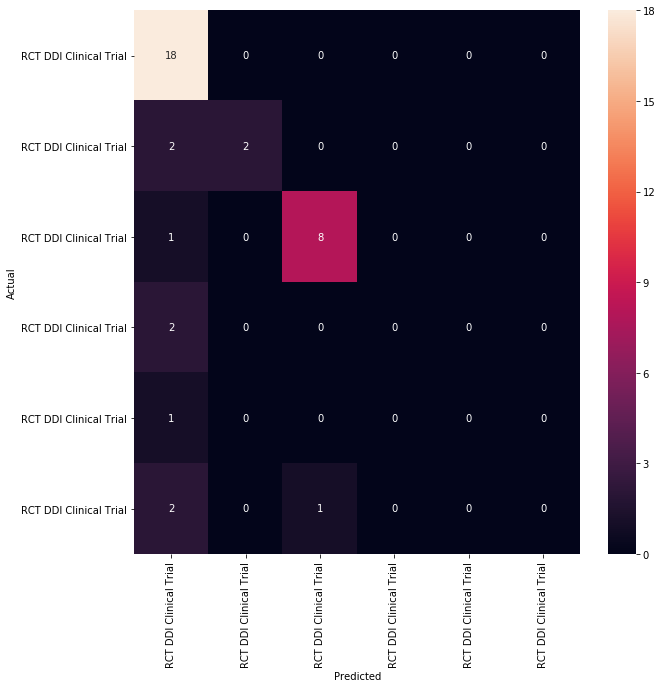

In [325]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')

# SVM Model with bigrams taken from Abstract, Article Title, & Methods Section text
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns


#Get bigrams from Title. Abstract, Methods Section
vectorizer = CountVectorizer(ngram_range=(2,2))
text = df['Abstract'] + df['Article Title'] + df['Methods Section']
bigram_features = vectorizer.fit_transform(text)


X_train_dtm = bigram_features
for column in df1.columns[1:]:
    X_train_dtm = hstack((X_train_dtm,np.array(df1[column])[:,None])).tocsr()
    
labels_level_1 = df.category_id_1
labels_level_2 = df.category_id_2
labels_level_3 = df.category_id_3

#Train multi-class SVM model 
X_train, X_test, y_train, y_test,  = train_test_split(X_train_dtm, labels_level_3, stratify = labels_level_3, test_size=0.2, random_state = 0)
model = SVC(kernel='linear', class_weight='balanced')
clf = model.fit(X_train, y_train)
predictions = clf.predict(X_test)

#Print Accurancy, ROC AUC, F1 Scores, Recall, Precision)
print ('Accuracy:', accuracy_score(y_test, predictions))
# print ('ROC AUC: ', roc_auc_score(y_test,predictions))
print ('Precision:', precision_score(y_test, predictions,
                                    average='weighted'))
print ('Recall:', recall_score(y_test, predictions,
                              average='weighted'))
print ('F1 score:', f1_score(y_test, predictions,average='weighted'))
print (classification_report(y_test,predictions))

conf_mat = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_3['Third Label'].values, yticklabels=category_id_df_3['Third Label'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
        

In [295]:
import warnings
warnings.filterwarnings('ignore')

#Combine classifiers level 1 & level 2
#Cross validation 10 fold
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
import numpy as np 
from sklearn.utils import class_weight

skf = StratifiedKFold(n_splits=5)
n_folds = skf.get_n_splits(X_train_dtm,labels_level_1)

level_1_accuracies = 0
level_1_roc_auc_scores =0
level_1_precisions =0
level_1_recalls =0
level_1_f1s =0

level2_DDI_accuracies = 0
level2_DDI_roc_auc_scores = 0
level2_DDI_precisions = 0
level2_DDI_recalls = 0
level2_DDI_f1s = 0

level2_PK_accuracies = 0
level2_PK_roc_auc_scores = 0
level2_PK_precisions = 0
level2_PK_recalls = 0
level2_PK_f1s = 0

level3_PK_accuracies = 0
level3_PK_roc_auc_scores = 0
level3_PK_precisions = 0
level3_PK_recalls = 0
level3_PK_f1s = 0

level3_DDI_accuracies = 0
level3_DDI_roc_auc_scores = 0
level3_DDI_precisions = 0
level3_DDI_recalls = 0
level3_DDI_f1s = 0

for train_index, test_index in skf.split(X_train_dtm,labels_level_1):
#     print("TRAIN:", train_index, "TEST:", test_index)
    #get the train/test sets for layer 1 classifier
    X_train, X_test =  X_train_dtm[train_index], X_train_dtm[test_index]     
    y_train, y_test = labels_level_1[train_index], labels_level_1[test_index]
    
    #fit and predict layer 1 classifier
    model = SVC(kernel='linear',class_weight="balanced")
    clf = model.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    #get result of layer 1 classifier
    level_1_accuracies += accuracy_score(y_test, predictions)
    level_1_roc_auc_scores += roc_auc_score(y_test,predictions)
    level_1_precisions += precision_score(y_test, predictions,average='weighted')
    level_1_recalls += recall_score(y_test, predictions,average='weighted')
    level_1_f1s += f1_score(y_test, predictions,average='weighted')
    
    ###------ LAYER 2 CLASSIFIERS------####

    #get index of data from layer 1 classifier for layer 2 classifiers (called DDI classifier & PK classifier)
    train__index_level2_DDI = (list(y_train[y_train==0].index))
    train__index_level2_PK = (list(y_train[y_train==1].index))
    test_index_level2_DDI = (list(y_test[y_test==0].index))
    test_index_level2_PK = (list(y_test[y_test==1].index))
    
    #get the train/test sets for layer 2 DDI classifier
    X_train_level2_DDI, X_test_level2_DDI =  X_train_dtm[train__index_level2_DDI], X_train_dtm[test_index_level2_DDI]     
    y_train_level2_DDI, y_test_level2_DDI = labels_level_2[train__index_level2_DDI], labels_level_2[test_index_level2_DDI]
    
    #fit layer 2 DDI classifier model 
    model_level2_DDI = SVC(kernel='linear',class_weight="balanced")
    clf_level2_DDI = model_level2_DDI.fit(X_train_level2_DDI, y_train_level2_DDI)
    predictions_level2_DDI = clf_level2_DDI.predict(X_test_level2_DDI)
    
    #get results layer 2 DDI classifier
    level2_DDI_accuracies += accuracy_score(y_test_level2_DDI, predictions_level2_DDI)
    level2_DDI_roc_auc_scores += roc_auc_score(y_test_level2_DDI,predictions_level2_DDI)
    level2_DDI_precisions += precision_score(y_test_level2_DDI, predictions_level2_DDI,average='weighted')
    level2_DDI_recalls += recall_score(y_test_level2_DDI, predictions_level2_DDI,average='weighted')
    level2_DDI_f1s += f1_score(y_test_level2_DDI, predictions_level2_DDI,average='weighted')

    #get the train/test sets for layer 2 PK classifier
    X_train_level2_PK, X_test_level2_PK =  X_train_dtm[train__index_level2_PK], X_train_dtm[test_index_level2_PK]     
    y_train_level2_PK, y_test_level2_PK = labels_level_2[train__index_level2_PK], labels_level_2[test_index_level2_PK]    
    
    #fit layer 2 PK classifier model 
    model_level2_PK = SVC(kernel='linear',class_weight="balanced")
    clf_level2_PK = model_level2_PK.fit(X_train_level2_PK, y_train_level2_PK)
    predictions_level2_PK = clf_level2_PK.predict(X_test_level2_PK)
    
    #get results layer 2 PK classifier
    level2_PK_accuracies += accuracy_score(y_test_level2_PK, predictions_level2_PK)
    level2_PK_precisions += precision_score(y_test_level2_PK, predictions_level2_PK,average='weighted')
    level2_PK_recalls += recall_score(y_test_level2_PK, predictions_level2_PK,average='weighted')
    level2_PK_f1s += f1_score(y_test_level2_PK, predictions_level2_PK,average='weighted')
    
    
    ###------ LAYER 3 CLASSIFIERS------####
    
    #get index of data from layer 2 classifier for layer 3 classifiers (called NonRCT classifier & PK classifier)
    train__index_level3_PK = (list(y_train_level2_PK[y_train_level2_PK==3].index))
    test_index_level3_PK = (list(y_test_level2_PK[y_test_level2_PK==3].index))
    train__index_level3_NonRCT = (list(y_train_level2_DDI[y_train_level2_DDI==2].index))
    test_index_level3_NonRCT = (list(y_train_level2_DDI[y_train_level2_DDI==2].index))
    
    #get the train/test sets for layer 3 PK Classifier (Phenotyped vs. Genotyped Trials)
    X_train_level3_PK, X_test_level3_PK =  X_train_dtm[train__index_level3_PK], X_train_dtm[test_index_level3_PK]     
    y_train_level3_PK, y_test_level3_PK = labels_level_3[train__index_level3_PK], labels_level_3[test_index_level3_PK]
    
    #fit model 
    model_level3_PK = SVC(kernel='linear',class_weight="balanced")
    clf_level3_PK = model_level3_PK.fit(X_train_level3_PK, y_train_level3_PK)
    predictions_level3_PK = clf_level3_PK.predict(X_test_level3_PK)
    
    #get results model level 3 Phenotyped vs. Genotyped Trials
    level3_PK_accuracies += accuracy_score(y_test_level3_PK, predictions_level3_PK)
    level3_PK_precisions += precision_score(y_test_level3_PK, predictions_level3_PK,average='weighted')
    level3_PK_recalls += recall_score(y_test_level3_PK, predictions_level3_PK,average='weighted')
    level3_PK_f1s += f1_score(y_test_level3_PK, predictions_level3_PK,average='weighted')
    
#     #Print out the row that are misclassified
#     for row_index, (X_test_item, prediction, label) in enumerate(zip (X_test_level3_PK, predictions_level3_PK, y_test_level3_PK)):
#         if prediction != label:
#             print ('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)

    ##get the train/test sets for layer 3 DDI Classifier (NonRCT vs. Non RCT Parallel Trial)
    X_train_level3_DDI, X_test_level3_DDI = X_train_dtm[train__index_level3_NonRCT], X_train_dtm[test_index_level3_NonRCT]     
    y_train_level3_DDI, y_test_level3_DDI = labels_level_3[train__index_level3_NonRCT], labels_level_3[test_index_level3_NonRCT]
        
    #calculate class weight for the NonRCT vs. NonRCT Parallel Trial (dataset is too small)
    from sklearn.utils.class_weight import compute_class_weight
    class_weight_list = compute_class_weight('balanced', np.unique(y_train_level3_DDI), y_train_level3_DDI)
    class_weight_customized = dict(zip(np.unique(y_train_level3_DDI), class_weight_list))
#     print (class_weight_customized)
    
    #fit model 
    model_level3_DDI = SVC(kernel='linear',class_weight=class_weight_customized)
    clf_level3_DDI = model_level3_DDI.fit(X_train_level3_DDI, y_train_level3_DDI)
    predictions_level3_DDI = clf_level3_DDI.predict(X_test_level3_DDI)
    
    #get results model level 3 NonRCT vs. Non RCT Parallel Trial
    level3_DDI_accuracies += accuracy_score(y_test_level3_DDI, predictions_level3_DDI)
    level3_DDI_precisions += precision_score(y_test_level3_DDI, predictions_level3_DDI,average='weighted')
    level3_DDI_recalls += recall_score(y_test_level3_DDI, predictions_level3_DDI,average='weighted')
    level3_DDI_f1s += f1_score(y_test_level3_DDI, predictions_level3_DDI,average='weighted')
    
    #Print out the row that are misclassified
#     for row_index, (X_test_item, prediction, label) in enumerate(zip (X_test_level3_DDI, predictions_level3_DDI, y_test_level3_DDI)):
#         if prediction != label:
#             print ('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
    
#Print level 1 result
print ("Results of classifier level 1: DDI clinical trials vs PK trials: ")
print ('Accuracy:', level_1_accuracies/n_folds)
print ('ROC AUC: ', level_1_roc_auc_scores/n_folds)
print ('Precision:', level_1_precisions/n_folds)
print ('Recall:', level_1_recalls/n_folds)
print ('F1 score:', level_1_f1s/n_folds)
print ("\n")

#Print level 2 DDI result
print ("Results of classifier level 2.1: RCT DDI clinical trials vs Non RCT clinical trials: ")
print ('Accuracy:', level2_DDI_accuracies/n_folds)
print ('ROC AUC: ', level2_DDI_roc_auc_scores/n_folds)
print ('Precision:', level2_DDI_precisions/n_folds)
print ('Recall:', level2_DDI_recalls/n_folds)
print ('F1 score:', level2_DDI_f1s/n_folds)
print ("\n")

#Print level 2 PK result
print ("Results of classifier level 2.2: PK trials vs Special PK trials: ")
print ('Accuracy:', level2_PK_accuracies/n_folds)
# print ('ROC AUC: ', level2_PK_roc_auc_scores/n_folds)
print ('Precision:', level2_PK_precisions/n_folds)
print ('Recall:', level2_PK_recalls/n_folds)
print ('F1 score:', level2_PK_f1s/n_folds)
print ("\n")

#Print level 3 PK result
print ("Results of classifier level 3.1: Genotyped trials vs Phenotyped trials: ")
print ('Accuracy:', level3_PK_accuracies/n_folds)
# print ('ROC AUC: ', level2_PK_roc_auc_scores/n_folds)
print ('Precision:', level3_PK_precisions/n_folds)
print ('Recall:', level3_PK_recalls/n_folds)
print ('F1 score:', level3_PK_f1s/n_folds)
print ("\n")

#Print level 3 DDI result
print ("Results of classifier level 3.1: NonRCT DDI clinical trials vs. Non RCT Parallel clinical trials: ")
print ('Accuracy:', level3_DDI_accuracies/n_folds)
# print ('ROC AUC: ', level2_PK_roc_auc_scores/n_folds)
print ('Precision:', level3_DDI_precisions/n_folds)
print ('Recall:', level3_DDI_recalls/n_folds)
print ('F1 score:', level3_DDI_f1s/n_folds)


Results of classifier level 1: DDI clinical trials vs PK trials: 
Accuracy: 0.8380828196617671
ROC AUC:  0.6597222222222222
Precision: 0.8668412586524041
Recall: 0.8380828196617671
F1 score: 0.8026035925398558


Results of classifier level 2.1: RCT DDI clinical trials vs Non RCT clinical trials: 
Accuracy: 0.9578817733990148
ROC AUC:  0.9462121212121213
Precision: 0.9627613658893684
Recall: 0.9578817733990148
F1 score: 0.9566796208254427


Results of classifier level 2.2: PK trials vs Special PK trials: 
Accuracy: 0.7527777777777778
Precision: 0.8563492063492063
Recall: 0.7527777777777778
F1 score: 0.7447138047138047


Results of classifier level 3.1: Genotyped trials vs Phenotyped trials: 
Accuracy: 0.6933333333333334
Precision: 0.7733333333333334
Recall: 0.6933333333333334
F1 score: 0.6933333333333334


Results of classifier level 3.1: NonRCT DDI clinical trials vs. Non RCT Parallel clinical trials: 
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0


In [ ]:




# #Print out the row that are misclassified
# for row_index, (X_test_item, prediction, label) in enumerate(zip (X_test, predictions, labels_level_1)):
#   if prediction != label:
#     print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)

# #Print out confusion matrix, True Positive, True Negative, False Positive, False Negative
# cm = confusion_matrix(y_test, predictions)
# print(cm)
# tn, fp, fn, tp = cm.ravel()
# print (tn, fp, fn, tp)

# #------------------------------
# #Plot Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, predictions)
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve')

# #------------------------------
# #Print ROC Curve
# # calculate roc curve
# from matplotlib import pyplot
# fpr, tpr, thresholds = roc_curve(y_test, predictions)
# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# pyplot.plot(fpr, tpr, marker='.')
# # show the plot
# pyplot.show()

# #-----------------------------